In [ ]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['OMP_NUM_THREADS'] = '4'


from bayesian_benchmarks.data import get_regression_data, get_classification_data
import bayesian_benchmarks.data as bd
import torch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm
from functools import partial
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import blackjax
from flax.training import train_state
import optax
import jaxopt

import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")
plt.rcParams["savefig.dpi"] = 75
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 8
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.facecolor"] = "white"
# plt.rcParams['grid.color'] = "grey"
plt.rcParams["text.usetex"] = True
# plt.rcParams['font.family'] = "normal"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams[
    "text.latex.preamble"
] = "\\usepackage{subdepth} \\usepackage{amsfonts} \\usepackage{type1cm}"


In [ ]:
from flax import linen as nn
from typing import Callable

def count_params(model, x):
    params = model.init(jax.random.PRNGKey(0), x)
    n = sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])
    print(f'Number of parameters: {n/1e3} k')
    
def param_size(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])

class MLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    act: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.H)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, nn.Dense(self.H)]
        layers += [self.act, nn.Dense(self.out_size)]
        return nn.Sequential(layers)(x)

def reparam_initializer(initializer, f):
    def init(key, shape, dtype=jnp.float32):
        # sample original parameters and then invert the reparametrization
        return f(initializer(key, shape, dtype))
    return init

class ReparamDense(nn.Module):
    # same as nn.Dense but with reparam weights
    # reparam: Callable = lambda x: x # w = reparam(x)
    # reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    # bias_init: Callable = reparam_initializer(nn.initializers.normal(stddev=1e-6))
    # kernel_init: Callable = reparam_initializer(nn.initializers.lecun_normal())

    def __init__(self, features, reparam, reparam_inv, init_scale=None):
        super().__init__()
        self.features = features
        self.reparam = reparam
        self.reparam_inv = reparam_inv
        # zero init for bias
        if init_scale is None:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=1e-4), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.lecun_normal(), f=reparam_inv)
        else:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)

    @nn.compact
    def __call__(self, inputs):
        reparam_kernel = self.param('reparam_kernel', self.kernel_init, (inputs.shape[-1], self.features))
        reparam_bias = self.param('reparam_bias', self.bias_init, (1, self.features)) # not using bias_init to avoid dividing by zero
        # invert weights
        kernel = jax.tree_util.tree_map(self.reparam, reparam_kernel)
        bias = jax.tree_util.tree_map(self.reparam, reparam_bias)
        # clamp to avoid numerical issues
        kernel = jnp.clip(kernel, a_min=-1e6, a_max=1e6)
        bias = jnp.clip(bias, a_min=-1e6, a_max=1e6)
        return jnp.dot(inputs, kernel) + bias

class ReparamMLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    reparam: Callable = lambda x: x # w = reparam(x)
    reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    act: Callable = nn.tanh
    init_scale: float = None

    @nn.compact
    def __call__(self, x):
        layers = [ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        layers += [self.act, ReparamDense(features=self.out_size, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        out = nn.Sequential(layers)(x)
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    d_model: int
    num_heads: int

    def setup(self):
        self.W_q = nn.Dense(self.d_model)
        self.W_k = nn.Dense(self.d_model)
        self.W_v = nn.Dense(self.d_model)
        self.W_o = nn.Dense(self.d_model)

    def attention(self, q, k, v, mask=None, dropout=None):
        # q, k: # (batch_size, num_heads, seq_len, d_model // num_heads)
        d_k = q.shape[-1]
        scores = jnp.einsum('...nd,...ed->...ne', q, k) / jnp.sqrt(d_k) # (batch_size, num_heads, seq_len, seq_len)
        if mask is not None:
            scores = scores - 1e9 * mask
        weights = nn.softmax(scores, axis=-1) # (batch_size, num_heads, seq_len, seq_len)
        output = jnp.matmul(weights, v) # (batch_size, num_heads, seq_len, d_model // num_heads)
        return output

    def __call__(self, x, mask=None, dropout=None):
        batch_size = x.shape[0]
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        q = q.reshape(batch_size, -1, self.num_heads, q.shape[-1] // self.num_heads).transpose(0, 2, 1, 3) # (batch_size, num_heads, seq_len, d_model // num_heads)
        k = k.reshape(batch_size, -1, self.num_heads, k.shape[-1] // self.num_heads).transpose(0, 2, 1, 3)
        v = v.reshape(batch_size, -1, self.num_heads, v.shape[-1] // self.num_heads).transpose(0, 2, 1, 3)
        if mask is not None:
            mask = mask[:, jnp.newaxis, :, :]
        output = self.attention(q, k, v, mask, dropout) # (batch_size, num_heads, seq_len, d_model // num_heads)
        output = output.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)
        return self.W_o(output)

class PositionWiseFeedForward(nn.Module):
    d_model: int
    d_ff: int

    def setup(self):
        self.fc1 = nn.Dense(self.d_ff)
        self.fc2 = nn.Dense(self.d_model)

    def __call__(self, x):
        return self.fc2(nn.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    d_model: int
    num_heads: int
    d_ff: int
    dropout_rate: float

    def setup(self):
        self.mha = MultiHeadAttention(self.d_model, self.num_heads)
        self.ffn = PositionWiseFeedForward(self.d_model, self.d_ff)
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()

    def __call__(self, x, mask=None):
        x = self.norm1(x + self.mha(x, mask))
        return self.norm2(x + self.ffn(x))

class TransformerEncoder(nn.Module):
    num_layers: int
    d_model: int
    num_heads: int
    d_ff: int
    dropout_rate: float

    def setup(self):
        self.layers = [EncoderLayer(self.d_model, self.num_heads, self.d_ff, self.dropout_rate)
                       for _ in range(self.num_layers)]

    def __call__(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class PositionalEncoding(nn.Module):
    d_model: int
    dropout_rate: float

    def __call__(self, x):
        seq_length = x.shape[1]
        position = jnp.arange(seq_length)[:, jnp.newaxis]
        div_term = jnp.exp(jnp.arange(0, self.d_model, 2) * -(jnp.log(10000.0) / self.d_model))
        pos_enc = jnp.zeros((1, seq_length, self.d_model))
        pos_enc[:, :, 0::2] = jnp.sin(position * div_term)
        pos_enc[:, :, 1::2] = jnp.cos(position * div_term)
        return x + pos_enc
    
class LearnedPositionalEncoding(nn.Module):
    d_model: int
    max_len: int

    def setup(self):
        self.pos_embedding = self.param('pos_embedding', nn.initializers.normal(), (1, self.max_len, self.d_model))

    def __call__(self, x):
        seq_length = x.shape[1]
        assert seq_length <= self.max_len, f"Input sequence length ({seq_length}) exceeds max_len ({self.max_len})."
        return x + self.pos_embedding[:, :seq_length, :]

class Transformer(nn.Module):
    out_size: int
    d_model: int
    num_heads: int
    num_layers: int
    d_ff: int
    max_len: int
    dropout_rate: float = 0

    def setup(self):
        self.embedding = nn.Dense(self.d_model)
        self.pos_enc = LearnedPositionalEncoding(self.d_model, self.max_len)
        self.encoder = TransformerEncoder(self.num_layers, self.d_model, self.num_heads, self.d_ff, self.dropout_rate)
        self.output_layer = nn.Dense(self.out_size)

    def __call__(self, x, mask=None):
        # we assume tabular data with shape (batch_size, feature_dim)
        # treat each feature as a token num_tokens == feature_dim
        # reshape to (batch_size, num_tokens, 1)
        x = x.reshape(x.shape[0], x.shape[1], 1)
        x = self.embedding(x)
        x = self.pos_enc(x)
        x = self.encoder(x, mask)
        x = self.output_layer(x) # (batch_size, num_tokens, out_size)
        x = jnp.mean(x, axis=1) # (batch_size, out_size)
        return x


In [ ]:
def tree_norm(tree):
    return jnp.sqrt(sum([jnp.sum(x**2) for x in jax.tree_leaves(tree)]))

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)

@jax.jit
def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )

def jacobian_sigular_values(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x) # (b, o, p)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('bo...->...bo', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    P = param_size(p)
    J = J.reshape(P, -1).T # (B*O, P)
    # sigular values of J
    _, S, _ = jnp.linalg.svd(J, full_matrices=False)
    return S

def get_K_matrix(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    N = x.shape[0]
    K = J.T @ J / N # (P, P)
    return K


@partial(jax.jit, static_argnums=(0,3,4))
def log_det_K_svd(model, p, x, jitter=1e-6, return_eig=False):
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = jnp.sum(jnp.log(s ** 2 + jitter))
    P = param_size(p)
    logdet_svd = logdet_svd - P * jnp.log(jitter)
    if return_eig:
        return logdet_svd, s ** 2
    return logdet_svd

@partial(jax.jit, static_argnums=(0,3,4))
def log_det_K_svd_first_order(model, p, x, jitter=1e-6, return_eig=False):
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = jnp.sum(jnp.log(jitter) + (s ** 2) / jitter)
    P = param_size(p)
    logdet_svd = logdet_svd - P * jnp.log(jitter)
    if return_eig:
        return logdet_svd, s ** 2
    return logdet_svd

def log_det_K(model, p, x, jitter=1e-6, scale=1.0):
    K = get_K_matrix(model, p, x)
    # add jitter
    K = K + jitter * jnp.eye(K.shape[0])
    s, log_det = jnp.linalg.slogdet(K)
    return log_det
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = 2 * jnp.sum(jnp.log(s))
    return logdet_svd


@partial(jax.jit, static_argnums=(0,4))
def trace_estimator(model, p, x, dp, sigma=0.1):
    # dp: N(0, I)
    # p_perturbed = p + dp, both pytrees
    # scale dp by sigma
    dp = jax.tree_util.tree_map(lambda x: x * sigma, dp)
    p_perturbed = jax.tree_util.tree_map(lambda x, y: x + y, p, dp)
    # compute the difference between the outputs
    y = model.apply(p, x)
    y_perturbed = model.apply(p_perturbed, x)
    diff = y - y_perturbed
    # compute the avg sq norm of the difference
    avg_dff_sq_norm = jnp.mean((diff ** 2).sum(axis=-1))
    return avg_dff_sq_norm / (sigma ** 2)

# @partial(jax.jit, static_argnums=(0,3,4,5,6))
def log_det_trace_estimator(model, p, x, jitter, dp, sigma=0.01, n_samples=1, normalize=False):
    # sample n_samples dp from N(0, I) and compute the trace estimator
    traces = []
    P = param_size(p)
    if normalize:
        scale = (P ** 0.5) / tree_norm(dp)
    else:
        scale = 1.0
    # scale dp to have squared norm P * sigma^2
    dp = jax.tree_util.tree_map(lambda x: x * scale, dp)
    trace = trace_estimator(model, p, x, dp, sigma=sigma)
    return trace / jitter

In [ ]:
def optimize(lr, prior_scale, n_step, rng_key, loss_fn, val_loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method='exact', temp=1.0):
    rng_key, init_params_key = jax.random.split(rng_key)
    init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, x_train.shape[1])))
    def get_train_state(optimizer, lr, init_params, warmup_steps=100):
        lr_sched = optax.linear_schedule(0, lr, warmup_steps, transition_begin=0)
        if optimizer == 'adam':
            tx = optax.chain(
                    optax.adam(learning_rate=lr_sched),
                )
            
        elif optimizer == 'sgd':
            tx = optax.sgd(learning_rate=lr_sched, momentum=0.9)
        else:
            raise NotImplementedError
        return train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)
    
    ts = get_train_state(optimizer, lr, init_params)
    
    def augmented_loss_fn(p, x_eval, dp):
        # loss = likelihood / N = 1 / (2 * sigma^2) * ||y - f(x)||^2 / N
        # it contains a factor 1 / N, where N = x_train.shape[0]
        # all other terms should be divided by N as well
        avg_nll = loss_fn(p) 
        N = x_train.shape[0]
        # number of params
        P = jax.tree_util.tree_leaves(p)[0].shape[0]
        if fsmap:
            if method == 'diag':
                logdet = 1 / 2 * log_det_diagonal_approx(model, p, x_eval, jitter) / N
            elif method == 'exact':
                # svd is much more stable
                logdet = 1 / 2 * log_det_K_svd(model, p, x_eval, jitter) / N
            elif method == 'laplacian':
                logdet = 1 / 2 * log_det_trace_estimator(model, p, x_eval, jitter, dp) / N
            else:
                raise NotImplementedError
        else:
            logdet = 0
        params_flat, unravel = jax.flatten_util.ravel_pytree(p)
        log_p_w = 1 / (2 * (prior_scale ** 2)) * jnp.sum(params_flat ** 2) / N
        logdet =  temp * logdet + (1 - temp) * jax.lax.stop_gradient(logdet)
        val_nll = val_loss_fn(p)
        return avg_nll + log_p_w + logdet, (avg_nll, val_nll, logdet)

    grad_fn = jax.jit(jax.value_and_grad(lambda p, x_eval, dp: augmented_loss_fn(p, x_eval, dp), has_aux=True))
    losses = []
    logdets = []
    avg_nlls = []
    val_nlls = []
    def sample_dp(p, rng_key):
        # gaussian tree
        dp = tree_random_normal_like(rng_key, p)
        # # norm of dp flattened
        # dp_flat, _ = jax.flatten_util.ravel_pytree(dp)
        # dp_norm = jnp.sqrt(jnp.sum(dp_flat ** 2))
        # # normalize dp
        # dp = jax.tree_util.tree_map(lambda x: x / dp_norm, dp)
        return dp
    @jax.jit
    def train_step(ts, rng_key):
        rng_key, x_eval_key = jax.random.split(rng_key)
        rng_key, dp_key = jax.random.split(rng_key)
        x_eval = x_eval_generator(x_eval_key)
        dp = sample_dp(ts.params, dp_key)
        (loss, aux), grads = grad_fn(ts.params, x_eval, dp)
        ts = ts.apply_gradients(grads=grads)
        return ts, loss, aux, rng_key
    for _ in tqdm(range(int(n_step))):
        ts, loss, aux, rng_key = train_step(ts, rng_key)
        avg_nll, val_nll, logdet = aux
        losses.append(loss.item())
        logdets.append(logdet.item())
        avg_nlls.append(avg_nll.item())
        val_nlls.append(val_nll.item())
    losses = np.array(losses)
    logdets = np.array(logdets)
    avg_nlls = np.array(avg_nlls)
    val_nlls = np.array(val_nlls)
    return ts.params, losses, avg_nlls, val_nlls, logdets

In [ ]:
def standardize(x_train, x_test):
    assert x_train.ndim == 2 and x_test.ndim == 2 and x_train.shape[1] == x_test.shape[1], 'x_train and x_test should have the same number of features'
    x_train = (x_train - x_train.mean(0)) / (x_train.std(0) + 1e-8)
    x_test = (x_test - x_train.mean(0)) / (x_train.std(0) + 1e-8)
    return x_train, x_test

def standardize_ds(x_train, y_train, x_test, y_test, is_classification):
    # X: (N, D)
    # Y: (N, Dy)
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    x_train, x_test = standardize(x_train, x_test)
    if is_classification:
        y_train = y_train.astype(np.int32)
        y_test = y_test.astype(np.int32)
    else:
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)
        y_train, y_test = standardize(y_train, y_test)
    return x_train, y_train, x_test, y_test

In [ ]:
import time

def to_one_hot(y_train, y_val, y_test):
    # y_train: (N,1)
    # y_test: (N,1)
    assert y_train.ndim == 2 and y_test.ndim == 2 and y_train.shape[1] == y_test.shape[1] == 1, 'y_train and y_test should have shape (N,1)'
    n_classes = y_train.max() + 1
    y_train = jax.nn.one_hot(y_train.reshape(-1), n_classes)
    y_val = jax.nn.one_hot(y_val.reshape(-1), n_classes)
    y_test = jax.nn.one_hot(y_test.reshape(-1), n_classes)
    return y_train, y_val, y_test

def run_dataset(dataset, arch, prior_scale, n_step, lr, optimizer, output_dir, seed, fsmap=False, method='exact', jitter=1e-6, temp=1, result_path=None):
    is_classification = dataset in bd.classification_datasets
    if is_classification:
        print(f'Running {dataset} classification dataset')
    else:
        print(f'Running {dataset} regression dataset')
    # get data
    ds = get_regression_data(dataset) if not is_classification else get_classification_data(dataset)
    x_train, y_train, x_test, y_test = ds.X_train, ds.Y_train, ds.X_test, ds.Y_test
    x_train, y_train, x_test, y_test = standardize_ds(x_train, y_train, x_test, y_test, is_classification)
    # 20% of training data as validation
    n_val = int(x_train.shape[0] * 0.2)
    # shuffle x_train and y_train
    indices = np.arange(x_train.shape[0])
    # fix seed
    np.random.seed(42)
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]
    x_train, x_val, y_train, y_val = x_train[n_val:], x_train[:n_val], y_train[n_val:], y_train[:n_val]
    if is_classification:
        y_train, y_val, y_test = to_one_hot(y_train, y_val, y_test)
    print(f"X train: {x_train.shape}, X val: {x_val.shape}, X test: {x_test.shape}")
    print(f"Y train: {y_train.shape}, Y val: {y_val.shape}, Y test: {y_test.shape}")
    # model
    model = arch(out_size=y_train.shape[1])
    def x_eval_generator(rng_key):
        # sample 200 points from normal distribution
        return jax.random.normal(rng_key, (1000, x_train.shape[1]))
    # count parameters
    init_params = model.init(jax.random.PRNGKey(0), jnp.ones((1, x_train.shape[1])))
    leaves, _ = jax.tree_util.tree_flatten(init_params)
    n_params = sum([np.prod(p.shape) for p in leaves])
    print(f"Number of parameters: {n_params}")

    # softmax multi-task cross entropy loss (not binary)
    if is_classification:
        loss_fn = lambda p, x, y: jnp.mean(jnp.sum(-jax.nn.log_softmax(model.apply(p, x), axis=1) * y, axis=1))
    else:
        loss_fn = lambda p, x, y: jnp.mean((model.apply(p, x) - y)**2)
    y_model = model.apply(init_params, x_test)
    assert y_model.shape == y_test.shape, f'model output shape: {y_model.shape}, y_test shape: {y_test.shape}'
    train_loss_fn = lambda p: loss_fn(p, x_train, y_train)
    test_loss_fn = lambda p: loss_fn(p, x_test, y_test)
    val_loss_fn = lambda p: loss_fn(p, x_val, y_val)
    
    rng_key = jax.random.PRNGKey(seed)
    # log training time
    start_time = time.time()
    params, losses, avg_nlls, val_nlls, logdets = optimize(lr, prior_scale, n_step, rng_key, train_loss_fn, val_loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method, temp)
    end_time = time.time()
    # train time in seconds
    train_time = end_time - start_time
    # plot and save losses
    plt.figure()
    
    def make_subplots(arrays, labels):
        n_plots = len(arrays)
        fig, axs = plt.subplots(n_plots, 1, figsize=(10, 10))
        for i, (a, label) in enumerate(zip(arrays, labels)):
            q1, q2 = np.quantile(a, [0., 0.95])
            axs[i].plot(a)
            axs[i].set_ylim(q1, q2)
            axs[i].set_xlabel('Step')
            axs[i].set_ylabel(label)
            axs[i].legend()
        plt.show()
    
    make_subplots([losses, avg_nlls, val_nlls, logdets], ['Loss', 'Train NLL', 'Val NLL', 'Logdet'])
    
    def log_posterior(model, params, x):
        log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
        # log_det, eigs = log_det_K_svd(model, params, x, jitter=1e-32, return_eig=True)
        # laplacian = log_det_K_svd_first_order(model, params, x, jitter=1)
        measurements = {
            'log_param_prior': log_param_prior.item(),
            # 'log_det': log_det.item(),
            # 'laplacian': laplacian.item(),
            'train_time': train_time,
            'jitter': jitter,
            'train_loss': train_loss_fn(params).item(),
            'test_loss': test_loss_fn(params).item(),
            'val_loss': val_loss_fn(params).item(),
            'dataset': dataset,
        }
        print(measurements)
        # return log_likelihood + log_param_prior - 1 / 2 * log_det
        return measurements
    
    # compute function space posterior 
    measurements = log_posterior(model, params, x_test)
    torch.save(measurements, result_path)

    return measurements

In [ ]:
activations = {
    'tanh': nn.tanh,
    'elu': nn.elu,
    'cos': jnp.cos,
    'sin': jnp.sin,
    'softplus': nn.softplus,
}


In [248]:
# PSMAP
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [128]
depths = [2]
acts = ['elu']


optimizer = 'adam'
lr = 1e-3
n_step = int(1e4)
prior_scales = [100]


skip_if_done = True
fsmap = False
temps = [1]
method = 'exact'
jitter = 1e-32

datasets = ['boston', 'concrete', 'energy', 'power', 'protein', 'winered']

pmap_results = []
for dataset in datasets:
    for width in widths:
        for depth in depths:
            for act in acts:
                for prior_scale in prior_scales:
                    for temp in temps:
                        output_dir = 'uci_psmap'
                        # mkdir if needed
                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)
                        for seed in range(1):
                            arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                            result_path = f'{output_dir}/{dataset}_mlp_{act}_l{depth}h{width}j{jitter}s{prior_scale}seed{seed}.pt'
                            if os.path.exists(result_path) and skip_if_done:
                                pmap_results.append(torch.load(result_path))
                                print('Loaded result from ', result_path)
                            else:
                                gt_params = None
                                pmap_results.append(run_dataset(dataset, arch, prior_scale, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter, result_path=result_path))

Loaded result from  uci_psmap/boston_mlp_elu_l2h128j1e-32s100seed0.pt
Loaded result from  uci_psmap/concrete_mlp_elu_l2h128j1e-32s100seed0.pt
Loaded result from  uci_psmap/energy_mlp_elu_l2h128j1e-32s100seed0.pt
Loaded result from  uci_psmap/power_mlp_elu_l2h128j1e-32s100seed0.pt
Loaded result from  uci_psmap/protein_mlp_elu_l2h128j1e-32s100seed0.pt
Loaded result from  uci_psmap/winered_mlp_elu_l2h128j1e-32s100seed0.pt


In [247]:
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [128]
depths = [2]
acts = ['elu']


optimizer = 'adam'
lr = 1e-3
n_step = int(1e4)
prior_scales = [100]


skip_if_done = True
fsmap = True
temps = [1]
method = 'laplacian'

datasets = ['boston', 'concrete', 'energy', 'power', 'protein', 'winered']
jitters = np.logspace(-1, 1, 3)

laplace_results = []
for dataset in datasets:
    for jitter in jitters:
        for width in widths:
            for depth in depths:
                for act in acts:
                    for prior_scale in prior_scales:
                        for temp in temps:
                            output_dir = 'uci_laplacian'
                            # mkdir if needed
                            if not os.path.exists(output_dir):
                                os.makedirs(output_dir)
                            for seed in range(1):
                                arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                                result_path = f'{output_dir}/{dataset}_mlp_{act}_l{depth}h{width}j{jitter}s{prior_scale}seed{seed}.pt'
                                if os.path.exists(result_path) and skip_if_done:
                                    laplace_results.append(torch.load(result_path))
                                    print('Loaded result from ', result_path)
                                else:
                                    gt_params = None
                                    laplace_results.append(run_dataset(dataset, arch, prior_scale, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter, result_path=result_path))

Loaded result from  uci_laplacian/boston_mlp_elu_l2h128j0.1s100seed0.pt
Loaded result from  uci_laplacian/boston_mlp_elu_l2h128j1.0s100seed0.pt
Loaded result from  uci_laplacian/boston_mlp_elu_l2h128j10.0s100seed0.pt
Loaded result from  uci_laplacian/concrete_mlp_elu_l2h128j0.1s100seed0.pt
Loaded result from  uci_laplacian/concrete_mlp_elu_l2h128j1.0s100seed0.pt
Loaded result from  uci_laplacian/concrete_mlp_elu_l2h128j10.0s100seed0.pt
Loaded result from  uci_laplacian/energy_mlp_elu_l2h128j0.1s100seed0.pt
Loaded result from  uci_laplacian/energy_mlp_elu_l2h128j1.0s100seed0.pt
Loaded result from  uci_laplacian/energy_mlp_elu_l2h128j10.0s100seed0.pt
Loaded result from  uci_laplacian/power_mlp_elu_l2h128j0.1s100seed0.pt
Loaded result from  uci_laplacian/power_mlp_elu_l2h128j1.0s100seed0.pt
Loaded result from  uci_laplacian/power_mlp_elu_l2h128j10.0s100seed0.pt
Loaded result from  uci_laplacian/protein_mlp_elu_l2h128j0.1s100seed0.pt
Loaded result from  uci_laplacian/protein_mlp_elu_l2h128

In [ ]:
pmap_results[0]

In [241]:
# L-MAP transformer


widths = [64]
depths = [4]
heads = 4

optimizer = 'adam'
lr = 1e-3
n_step = int(1e3)
prior_scales = [100]


skip_if_done = False
fsmap = True
temps = [1]
method = 'laplacian'
jitter = 1e-32

datasets = ['boston', 'concrete', 'energy', 'power', 'protein', 'winered']
jitters = np.logspace(-2, 4, 7)

pmap_results = []
for dataset in datasets:
    for jitter in jitters:
        for width in widths:
            for depth in depths:
                for act in acts:
                    for prior_scale in prior_scales:
                        for temp in temps:
                            output_dir = 'uci_laplacian'
                            # mkdir if needed
                            if not os.path.exists(output_dir):
                                os.makedirs(output_dir)
                            for seed in range(1):
                                arch = partial(Transformer, d_model=width, num_heads=heads, num_layers=depth, max_len=100, d_ff=width, dropout_rate=0)
                                result_path = f'{output_dir}/{dataset}_transformer_{act}_l{depth}h{width}j{jitter}s{prior_scale}seed{seed}.pt'
                                if os.path.exists(result_path) and skip_if_done:
                                    pmap_results.append(torch.load(result_path))
                                    print('Loaded result from ', result_path)
                                else:
                                    gt_params = None
                                    pmap_results.append(run_dataset(dataset, arch, prior_scale, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter, result_path=result_path))

Running energy regression dataset
X train: (553, 8), X val: (138, 8), X test: (77, 8)
Y train: (553, 1), Y val: (138, 1), Y test: (77, 1)
Number of parameters: 107457


KeyboardInterrupt: 

In [249]:
# convert laplace results to pandas dataframe
import pandas as pd
df_laplace = pd.DataFrame(laplace_results)
df_psmap = pd.DataFrame(pmap_results)
df_laplace['method'] = 'L-MAP'
df_psmap['method'] = 'PS-MAP'

# require jitter to be > 1 for L-MAP
# df_laplace = df_laplace[df_laplace['jitter'] > 1]

# take RMSE
df_psmap['test_loss'] = df_psmap['test_loss'] ** 0.5
df_laplace['test_loss'] = df_laplace['test_loss'] ** 0.5

/tmp/ipykernel_2414626/3542109859.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('abbi/uci_scan.pdf', bbox_inches='tight')
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


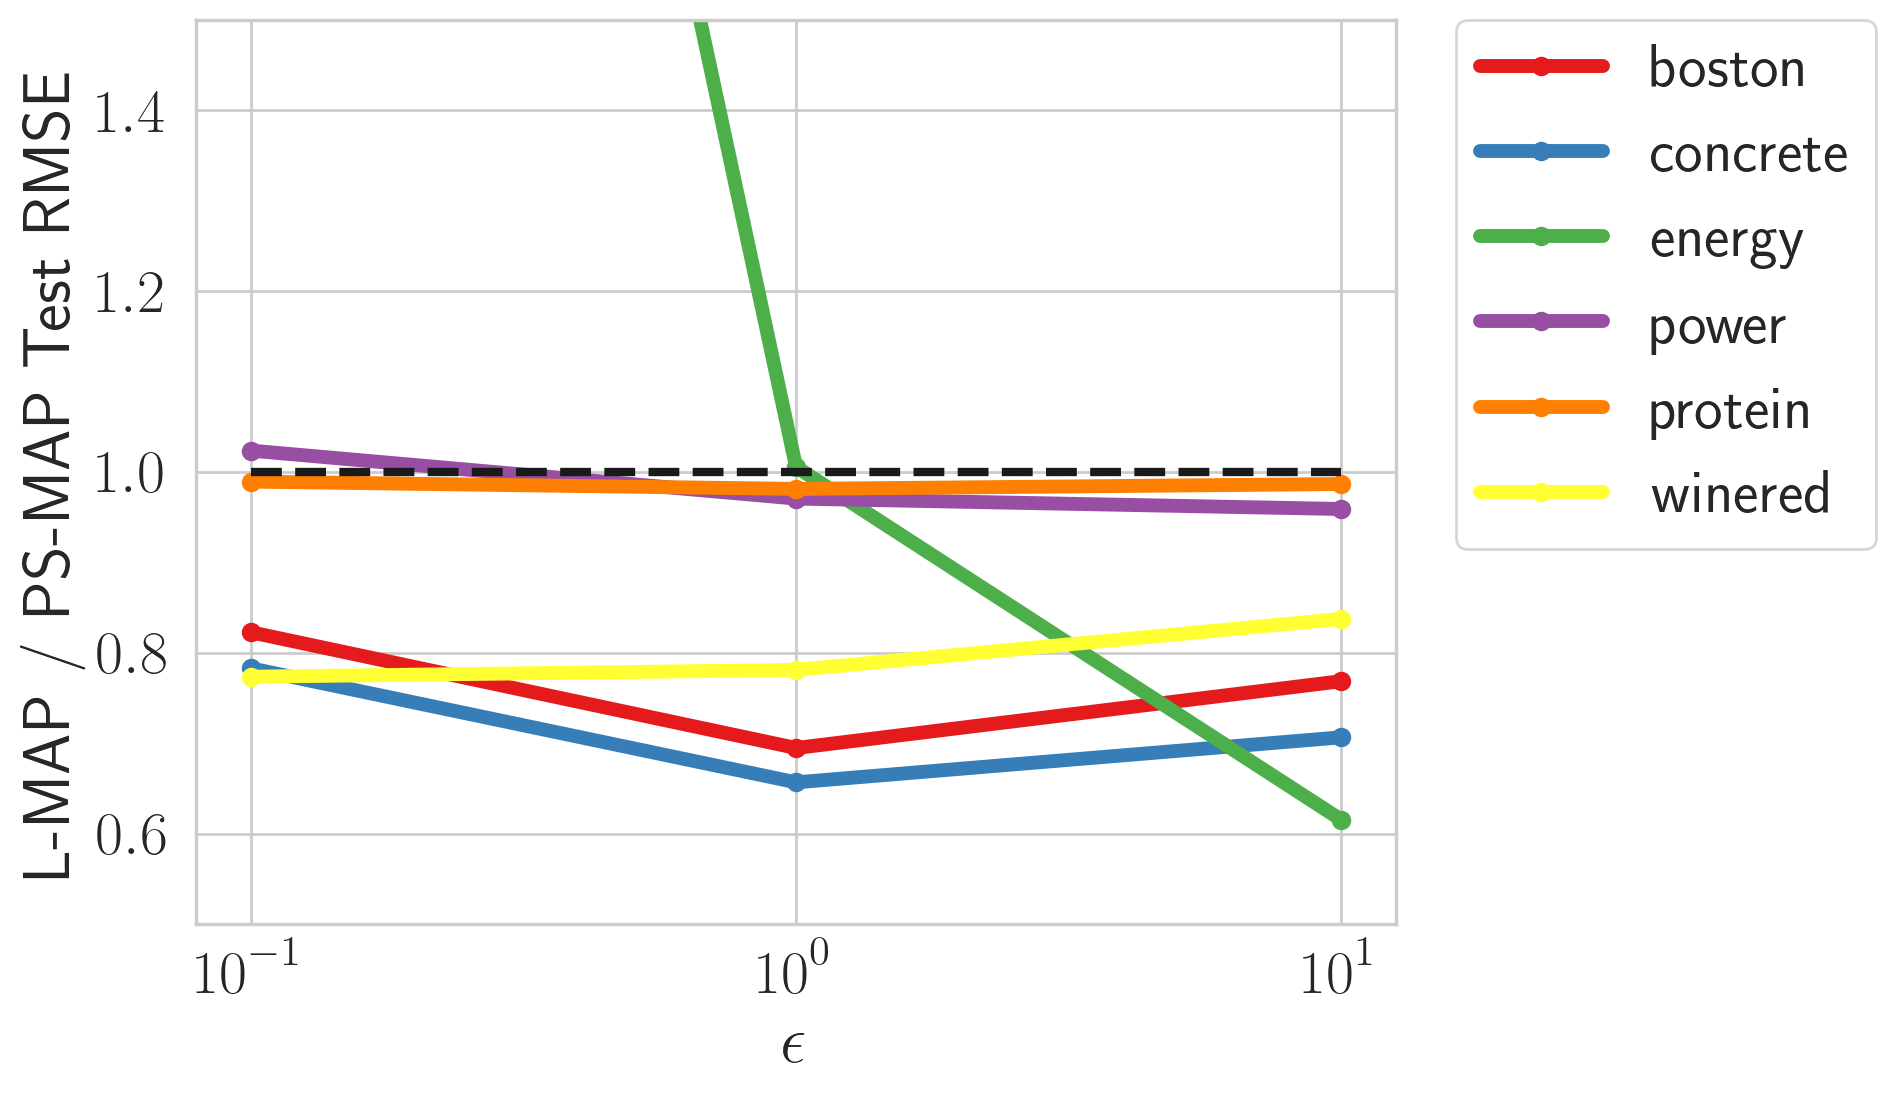

In [261]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")
# for each dataset
plt.figure(figsize=(10, 6), dpi=200)
# ratios = []
psmap_test_losses = []
worst_laplace_test_losses = []
for dataset in datasets:
    psmap_test_loss = float(df_psmap['test_loss'][df_psmap['dataset'] == dataset])
    laplace_test_loss = np.array(df_laplace['test_loss'][df_laplace['dataset'] == dataset])
    worst_laplace_test_losses.append(np.max(laplace_test_loss))
    psmap_test_losses.append(psmap_test_loss)
    jitters = np.array(df_laplace['jitter'][df_laplace['dataset'] == dataset])
    # ratios.append((laplace_test_loss/psmap_test_loss).item())
    plt.plot(jitters, laplace_test_loss/psmap_test_loss, label=dataset, marker='o', linewidth=5.0)

# a line at 1
min_ = np.min(jitters)
max_ = np.max(jitters)
plt.plot([min_, max_], [1, 1], 'k--')
# max y at 2
plt.ylim(0.5, 1.5)
plt.xlabel(r'$\epsilon$')
plt.ylabel('L-MAP / PS-MAP Test RMSE')
plt.xscale('log')
# legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('abbi/uci_scan.pdf', bbox_inches='tight')

/tmp/ipykernel_2414626/3539284246.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('abbi/uci_worst.pdf', bbox_inches='tight')
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


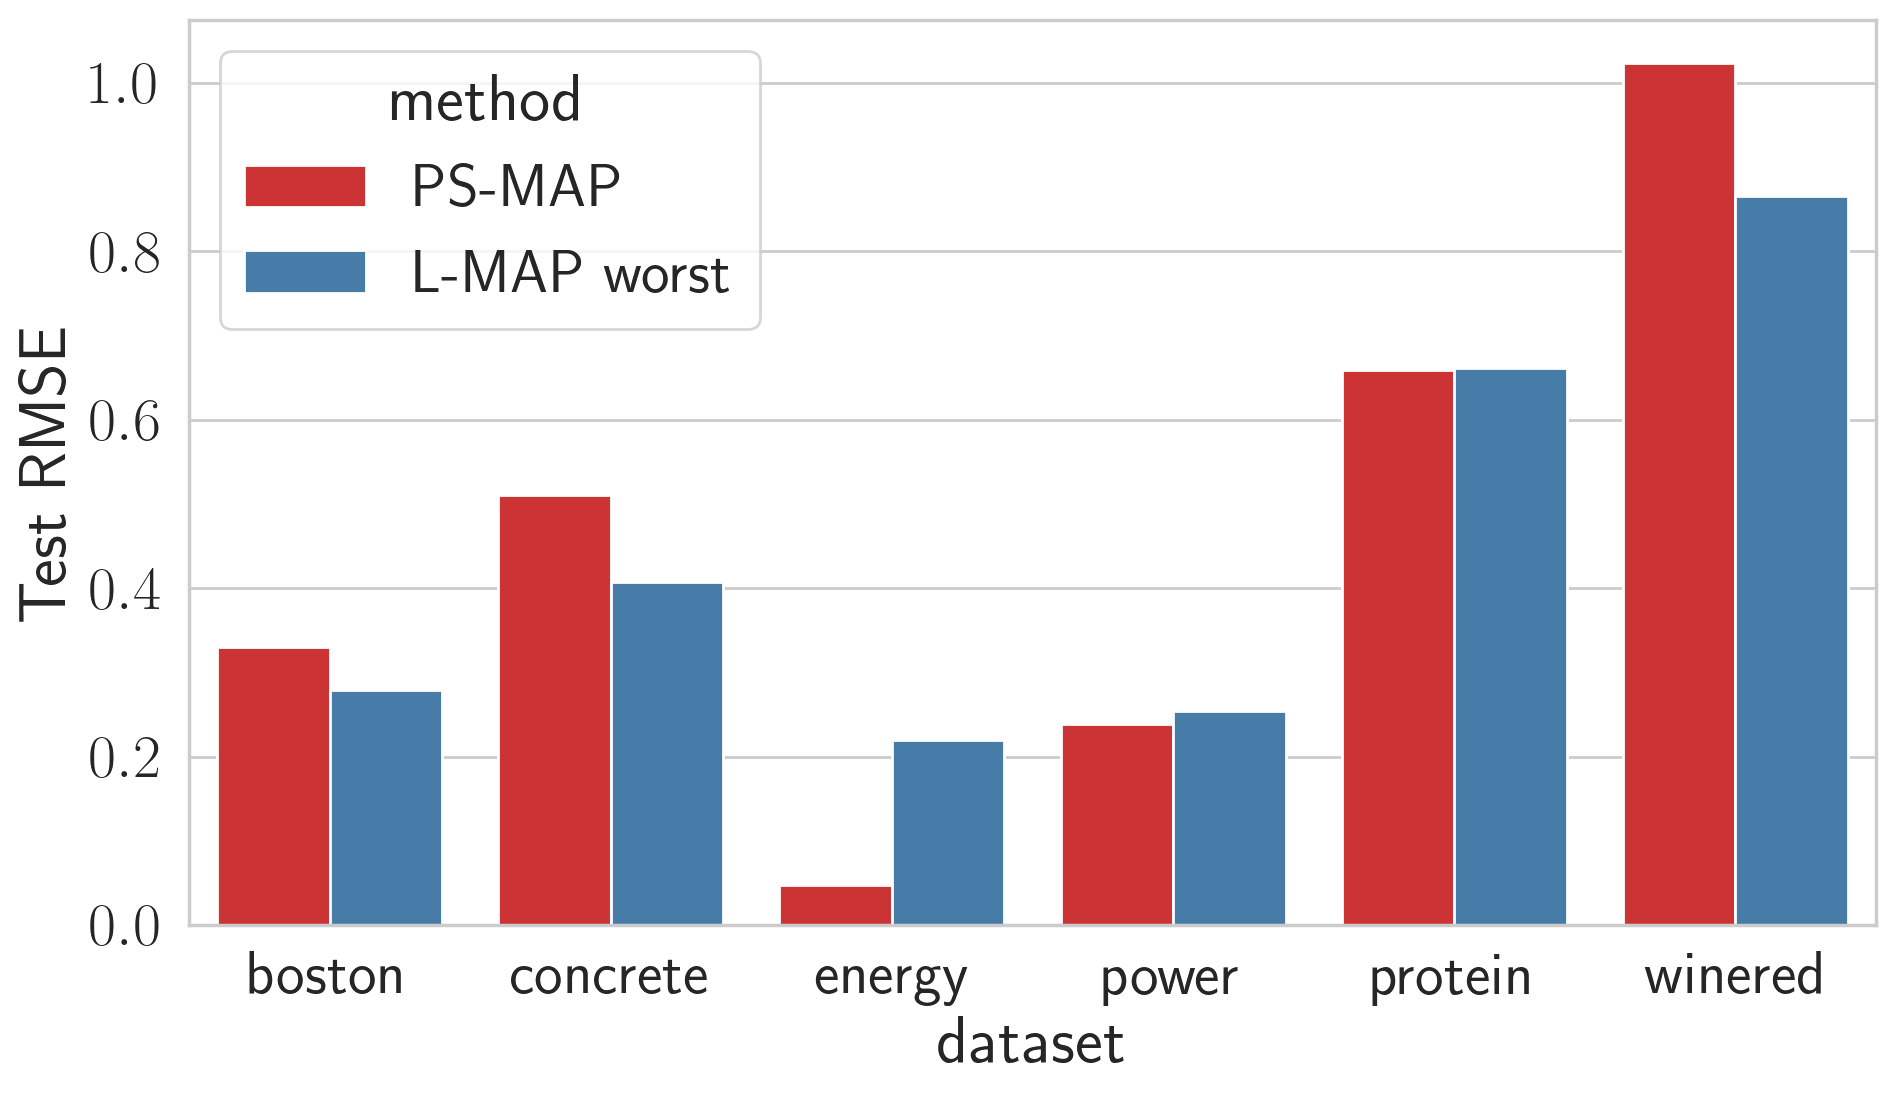

In [263]:
# bar plot of best test loss 
plt.figure(figsize=(10, 6), dpi=200)
df_best = pd.DataFrame({'dataset': datasets, 'PS-MAP': psmap_test_losses, 'L-MAP worst': worst_laplace_test_losses})
df_best = df_best.melt('dataset', var_name='method', value_name='test_loss')
sns.barplot(x='dataset', y='test_loss', hue='method', data=df_best)
plt.ylabel('Test RMSE')
plt.savefig('abbi/uci_worst.pdf', bbox_inches='tight')
# plt.yscale('log')
# plot ratios


/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


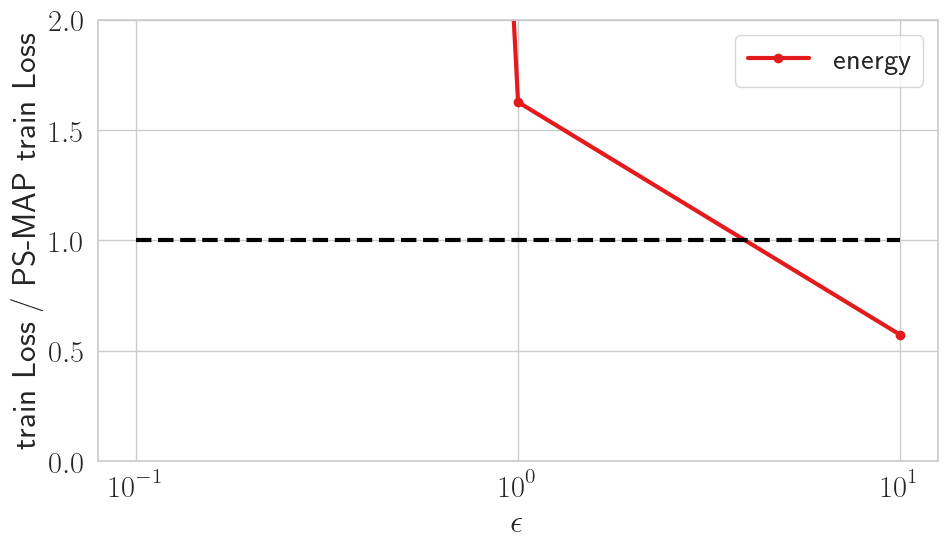

In [242]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")
# for each dataset
plt.figure(figsize=(10, 6))
for dataset in datasets:
    psmap_train_loss = float(df_psmap['train_loss'][df_psmap['dataset'] == dataset])
    laplace_train_loss = np.array(df_laplace['train_loss'][df_laplace['dataset'] == dataset])
    jitters = np.array(df_laplace['jitter'][df_laplace['dataset'] == dataset])
    plt.plot(jitters, laplace_train_loss/psmap_train_loss, label=dataset, marker='o')
# a line at 1
plt.plot(np.logspace(-1, 1, 100), np.ones(100), linestyle='--', color='black')
# max y at 2
plt.ylim(0, 2)
plt.xlabel(r'$\epsilon$')
plt.ylabel('train Loss / PS-MAP train Loss')
plt.xscale('log')
plt.legend()

In [ ]:
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [16]
depths = [2]
acts = ['tanh']


optimizer = 'adam'
lr = 1e-2
n_step = int(1e4)
prior_scales = [1]
noise_scale = 0
# n_eval = 400
# x_lims = [-5, 5]

def x_eval_generator(rng_key):
    X_eval = x_test
    return X_eval

skip_if_done = True
fsmap = True
temps = [1]
method = 'exact'
# jitter = 1e-32

exact_results = []
for jitter in [1e-32] + [j for j in np.logspace(-6, 3, 10)]:
    for width in widths:
        for depth in depths:
            for act in acts:
                for prior_scale in prior_scales:
                    for temp in temps:
                        output_dir = f'pathology'
                        # mkdir if needed
                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)
                        for seed in range(1):
                            arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                            result_path = f'{output_dir}/result_{seed}.pt'
                            if os.path.exists(result_path) and skip_if_done:
                                exact_results.append(torch.load(result_path))
                                print('Loaded result from ', result_path)
                            else:
                                gt_params = None
                                exact_results.append(run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter, result_path=result_path))
                                plt.show()
                                plt.savefig(f'two_moons_exact/{act}_l{depth}h{width}j{jitter}_pred.png')

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

def subtract_min(x):
    return x
    # return x - np.min(x)

def normalize(v):
    v_norm2 = jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(v)]))
    v = jax.tree_util.tree_map(lambda x: x / jnp.sqrt(v_norm2), v)    
    return v

def log_posterior(model, params, x_train, y_train, x_context, jitter, log_det_fn):
    y_train_one_hot = jax.nn.one_hot(y_train.reshape(-1), 2)
    log_likelihood = jnp.sum(jnp.sum(jax.nn.log_softmax(model.apply(params, x_train), axis=1) * y_train_one_hot, axis=1))
    log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
    log_det = log_det_fn(model, params, x_context, jitter)
    # print(f'log_likelihood: {log_likelihood}, log_param_prior: {log_param_prior}, log_det: {log_det}')
    return log_likelihood, log_param_prior, log_det

def scan_posterior(model, x_context, jitter, steps, max_alpha=1, log_det_fn=log_det_K_svd):
    rng_key = jax.random.PRNGKey(0)
    init_params = model.init(rng_key, x_train)
    # split key
    rng_key, rng_key_sample_1, rng_key_sample_2, rng_key_sample_3 = jax.random.split(rng_key, 4)
    # gaussian random param
    v1 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_1, x.shape), init_params))
    v2 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_2, x.shape), init_params))
    v3 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_3, x.shape), init_params))
    # plot log posterior on the ray spanned by 
    alpha = jnp.concatenate([-jnp.logspace(jnp.log10(max_alpha), -4, steps), jnp.logspace(-4, jnp.log10(max_alpha), steps)])
    alpha = alpha[alpha != 0]

    log_likelihoods, log_param_priors, log_dets = [], [], []
    log_posterior_fn = jax.jit(lambda p: log_posterior(model, p, x_train, y_train, x_context, jitter, log_det_fn))
    for a in tqdm(alpha):
        for v in [v1, v2, v3]:
            params = jax.tree_util.tree_map(lambda x: x * a, v)
            log_likelihood, log_param_prior, log_det = log_posterior_fn(params)
            log_likelihoods.append(log_likelihood)
            log_param_priors.append(log_param_prior)
            log_dets.append(log_det)

    log_likelihoods = jnp.array(log_likelihoods).reshape(-1, 3)
    log_param_priors = jnp.array(log_param_priors).reshape(-1, 3)
    log_dets = jnp.array(log_dets).reshape(-1, 3)
    return alpha, log_likelihoods, log_param_priors, log_dets

def plot_scan(alpha, log_likelihoods, log_param_priors, log_dets):
    # plot three quantities, as dots not lines
    plt.figure(dpi=100, figsize=(10, 6))
    for i in range(3):
        plt.plot(alpha, -log_likelihoods[:, i], label=r'NLL', color=f'C{i}', linestyle='--')
        plt.plot(alpha, subtract_min(-log_param_priors[:, i]), label=r'$-\Delta\log p_w$', color=f'C{i}', linestyle=':')
        plt.plot(alpha[alpha<0], 1/2 * subtract_min(log_dets[alpha<0, i]), label=rf'$\Delta1/2\log\det$', color=f'C{i}', linestyle='-')
        plt.plot(alpha[alpha>0], 1/2 * subtract_min(log_dets[alpha>0, i]), color=f'C{i}', linestyle='-')
    # put legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel(r'$\alpha$')
    plt.tight_layout()
    # plt.savefig('divergence.pdf')



In [ ]:
def scan_posterior_2d(model, x_context, jitter, steps, max_alpha=1, log_det_fn=log_det_K_svd):
    rng_key = jax.random.PRNGKey(0)
    init_params = model.init(rng_key, x_train)
    # split key
    rng_key, rng_key_sample_1, rng_key_sample_2, rng_key_sample_3 = jax.random.split(rng_key, 4)
    # gaussian random param
    v1 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_1, x.shape), init_params))
    v2 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_2, x.shape), init_params))
    # plot log posterior on the ray spanned by v1 and v2
    alpha = jnp.concatenate([-jnp.logspace(jnp.log10(max_alpha), -4, steps), jnp.logspace(-4, jnp.log10(max_alpha), steps)])
    alpha = alpha[alpha != 0]
    # 2d coordinates
    u, v = jnp.meshgrid(alpha, alpha)
    log_likelihoods, log_param_priors, log_dets = [], [], []
    log_posterior_fn = jax.jit(lambda p: log_posterior(model, p, x_train, y_train, x_context, jitter, log_det_fn))
    for a, b in tqdm(zip(u.flatten(), v.flatten())):
        av1 = jax.tree_util.tree_map(lambda x: x * a, v1)
        bv2 = jax.tree_util.tree_map(lambda x: x * b, v2)
        params = jax.tree_util.tree_map(lambda x, y: x + y, av1, bv2)
        log_likelihood, log_param_prior, log_det = log_posterior_fn(params)
        log_likelihoods.append(log_likelihood)
        log_param_priors.append(log_param_prior)
        log_dets.append(log_det)
    log_likelihoods = jnp.array(log_likelihoods)
    log_param_priors = jnp.array(log_param_priors)
    log_dets = jnp.array(log_dets)
    return u, v, log_likelihoods, log_param_priors, log_dets
    
def plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets):
    # three subplots
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(30, 10))
    # plot delta log det
    axs[0].contourf(u, v, subtract_min(log_dets).reshape(u.shape), levels=20)
    axs[0].set_title(r'$\Delta\log\det$')
    axs[0].set_xlabel(r'$\alpha$')
    axs[0].set_ylabel(r'$\beta$')
    # make image square
    axs[0].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[0].contourf(u, v, subtract_min(log_dets).reshape(u.shape), levels=20), ax=axs[0])
    # plot NLL
    axs[1].contourf(u, v, -log_likelihoods.reshape(u.shape), levels=20)
    axs[1].set_title(r'NLL')
    axs[1].set_xlabel(r'$\alpha$')
    axs[1].set_ylabel(r'$\beta$')
    axs[1].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[1].contourf(u, v, -log_likelihoods.reshape(u.shape), levels=20), ax=axs[1])
    # plot delta -log p_w
    axs[2].contourf(u, v, subtract_min(-log_param_priors).reshape(u.shape), levels=20)
    axs[2].set_title(r'$-\Delta\log p_w$')
    axs[2].set_xlabel(r'$\alpha$')
    axs[2].set_ylabel(r'$\beta$')
    axs[2].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[2].contourf(u, v, subtract_min(-log_param_priors).reshape(u.shape), levels=20), ax=axs[2])
    plt.tight_layout()

def plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets):
    # same but plot in 3d
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(u, v, subtract_min(log_dets).reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'$\Delta\log\det$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'$\Delta\log\det$')
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(u, v, -log_likelihoods.reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'NLL')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'NLL')
    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(u, v, subtract_min(-log_param_priors).reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'$-\Delta\log p_w$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'$-\Delta\log p_w$')
    plt.tight_layout()

In [ ]:
width = 16
depth = 2
act = 'tanh'
prior_scale = 1
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)
count_params(model, x_train)
x_context = x_test

for jitter in [1000]:
    alpha, log_likelihoods, log_param_priors, log_dets = scan_posterior(model, x_context, jitter, steps=10, max_alpha=1)
    plot_scan(alpha, 0*log_likelihoods, 0*log_param_priors, log_dets)
    plt.show()
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.png')
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.pdf')

In [ ]:
width = 16
depth = 2
act = 'tanh'
prior_scale = 1
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)
count_params(model, x_train)
x_context = x_test

log_det_fn = lambda model, p, x, jitter: log_det_trace_estimator(model, p, x, jitter, sigma=0.01, n_samples=10)
for jitter in [1000]:
    alpha, log_likelihoods, log_param_priors, log_dets = scan_posterior(model, x_context, jitter, steps=10, max_alpha=1, log_det_fn=log_det_fn)
    plot_scan(alpha, 0*log_likelihoods, 0*log_param_priors, log_dets)
    plt.show()
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.png')
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.pdf')

In [ ]:
width = 16
depth = 2
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

for jitter in [1e-1]:
    u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=100)
    torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}.pt')
    plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour.png')
    plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface.png')

In [ ]:
width = 16
depth = 2
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

log_det_fn = lambda model, p, x, jitter: log_det_trace_estimator(model, p, x, jitter, sigma=0.1, n_samples=10)
for jitter in [1e-1]:
    u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=100, log_det_fn=log_det_fn)
    torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}.pt')
    plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour_tr.png')
    plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface_tr.png')

In [ ]:
width = 16
depth = 4
act = 'elu'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

for jitter in [1e-32, 1e-6, 1e-3]:
    u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=100)
    torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}.pt')
    plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour.png')
    plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface.png')

In [ ]:
width = 16
depth = 2
act = 'elu'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

jitter = 1e-32
u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=1000)
torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}_wide.pt')
plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour_wide.png')
plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface_wide.png')

In [ ]:
width = 16
depth = 4
act = 'elu'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

jitter = 1e-32
u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=1000)
torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}_wide.pt')
plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour_wide.png')
plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface_wide.png')

## Comparing objectives ##

In [ ]:
width = 16
depth = 2
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

rng_key = jax.random.PRNGKey(0)
init_params = model.init(rng_key, x_train)
# log_det_K_svd_fn = jax.jit(lambda params, x_context, jitter: log_det_K_svd(model, params, x_context, jitter, return_eig=True), static_argnums=(3,))
# log_det_trace_estimator_fn = jax.jit(lambda params, x_context, jitter, sigma, n_samples: log_det_trace_estimator(model, params, x_context, jitter, sigma, n_samples), static_argnums=(3,4,5))

In [ ]:
points = 50
x_context = x_test
jitter = 1000
# trace estimator
n_samples = 100
sigma = 0.001 # noise scale

logdet_svds = []
logdet_traces = []
max_eigs = []
for _ in tqdm(range(points)):
    rng_key, rng_key_sample = jax.random.split(rng_key)
    params = model.init(rng_key_sample, x_train[0][None, :])
    logdet_svd, eig = log_det_K_svd(model, params, x_context, jitter, return_eig=True)
    logdet_svds.append(logdet_svd)
    max_eigs.append(eig.max().item())
    logdet_traces.append(log_det_trace_estimator(model, params, x_context, jitter, sigma, n_samples).item())

logdet_traces = np.array(logdet_traces)
logdet_svds = np.array(logdet_svds)
    

In [ ]:
ratio = (logdet_traces / logdet_svds)
_ = plt.hist(ratio, bins=20)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

# a nice square plot to compare logdet_svds, logdet_traces
# color the points by min_eig and plot a colorbar

plt.figure(figsize=(6,6))
plt.scatter(logdet_svds, logdet_traces, c=max_eigs, cmap='viridis')

plt.colorbar()
# # a diagonal line spanning the range of the data
min_logdet = min(min(logdet_svds), min(logdet_traces))
max_logdet = max(max(logdet_svds), max(logdet_traces))
plt.plot([0, max_logdet], [0, max_logdet], 'k--')

# label the axes
plt.xlabel('logdet svd')
plt.ylabel('logdet trace')

